In [6]:
import numpy as np
import pandas as pd
import rebound
from celmech import Andoyer, AndoyerHamiltonian
import dask.dataframe as dd
from celmech import *
from celmech.resonances import resonant_period_ratios
from celmech.andoyer import get_num_fixed_points
from collections import OrderedDict
import random
import itertools
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('paper')
respath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/stabilitydataset/data/resonant/'
sapath = 'simulation_archives/runs/sa'

# Ressummary features Performance Summary

Nominal feature set is: Betas, Zcross, Res Strengths, AMD features, EM features, MEGNO features. Test the performance relative to nominal of adding or subtracting sets of features, as measured by the precision recall AUC:

- Nominal: AUC = 0.895
- All: Nominal + res features (Zstar, Zfree etc.): AUC = 0.904
- Nominal-AMD: AUC = 0.862
- Nominal-Betas: AUC = 0.882
- Nominal-Strengths: AUC = 0.883
- Nominal-EM: AUC = 0.863
- Nominal-MEGNO: AUC = 0.880

In [7]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
featurefolder = 'ressummaryfeaturesxgbNorbits10000.0Nout1000/'
features = None
trainingdatafolder = datapath+dset+featurefolder
dataset = pd.read_csv(trainingdatafolder+"trainingdata.csv", index_col = 0)

In [8]:
dataset.head()

,C_AMD12,C_AMD23,C_AMD_max,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,...,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23,tlyap,megno
0,0.042895,27.354537,27.354537,0.504063,0.594658,0.060234,12.0,1.0,2.0,3.0,...,0.022942,0.000753,0.144823,0.004244,0.165598,0.033893,0.013167,-0.342346,-965263.814382,1.994241
1,0.779755,2.190450,2.190450,0.240504,0.340424,0.080547,9.0,1.0,2.0,3.0,...,0.037659,0.001800,0.050964,0.002007,0.027374,0.004149,0.069011,-0.684761,-572568.350739,2.003973
2,32.340940,0.005296,32.340940,0.129660,1.261558,1.001981,6.0,1.0,1.0,2.0,...,0.429699,0.013802,0.657982,0.019529,0.004231,0.000196,0.020795,0.000067,-124173.227388,2.011256
3,0.949707,0.692919,0.949707,0.406112,1.007603,0.427768,5.0,2.0,1.0,2.0,...,0.837173,0.054418,0.949626,0.048283,NaN,NaN,0.081875,0.000228,-459360.721938,2.010301
4,5.847346,0.238150,5.847346,0.059897,0.332922,0.257596,12.0,1.0,1.0,2.0,...,4.495888,0.297336,5.267933,0.106736,NaN,NaN,0.082738,0.001040,61481.585726,2.218560


In [9]:
labels = pd.read_csv(trainingdatafolder+"labels.csv", index_col=0)
labels.head()

,runstring,instability_time,shadow_instability_time,Stable
0,0000000.bin,1.545872e+06,3.063700e+06,False
1,0000001.bin,9.990000e+08,9.990000e+08,True
2,0000002.bin,9.990000e+08,9.990000e+08,True
3,0000003.bin,2.287671e+06,8.392234e+06,False
4,0000004.bin,9.668931e+05,3.380350e+05,False


In [10]:
dataset[(dataset['maxstrength'] > 0.5) & (labels['instability_time'] < 1.e6)].head()

,C_AMD12,C_AMD23,C_AMD_max,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,...,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23,tlyap,megno
46,3.748323,2.984749,3.748323,0.130276,0.276386,0.129269,6.0,1.0,2.0,3.0,...,0.271160,0.013761,0.552940,0.020191,0.407404,0.099649,0.228956,-0.081859,1070.760838,11.271553
93,1.671270,0.386003,1.671270,0.351709,1.080144,0.538899,3.0,2.0,1.0,3.0,...,0.169575,0.009931,0.824409,0.024046,0.191132,0.006681,0.130438,0.003925,5957.310923,3.531672
94,1.699110,4.613527,4.613527,0.587331,1.038431,0.284188,2.0,1.0,1.0,2.0,...,0.342522,0.014241,6.242497,0.018095,0.369412,0.022235,0.209088,-0.004405,548.924670,16.222594
115,10.095468,63.329879,63.329879,0.587681,0.832907,0.154456,2.0,1.0,1.0,2.0,...,0.020840,0.001454,0.132577,0.004095,0.485246,0.017778,0.170028,0.026677,325.277656,28.517659
122,1.944687,3.029348,3.029348,0.387371,0.681026,0.211663,4.0,1.0,2.0,3.0,...,0.078307,0.002751,0.166664,0.005609,0.144237,0.016266,0.020306,-0.456471,1268.009542,9.425375


In [11]:
dataset[(dataset['maxstrength'] > 0.5) & (labels['instability_time'] < 5.e8) & (labels['instability_time'] > 5.e7)].head()

,C_AMD12,C_AMD23,C_AMD_max,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,...,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23,tlyap,megno
68,1.044825,0.596613,1.044825,0.466753,1.080115,0.418176,3.0,2.0,1.0,3.0,...,0.434517,0.012349,1.409845,0.042312,NaN,0.104029,0.106437,0.002371,4.429863e+03,3.538739
110,1.090516,0.005173,1.090516,0.155855,1.080177,0.799688,3.0,2.0,1.0,3.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.679391e+04,1.826459
176,1.682510,8.847884,8.847884,0.257910,0.405737,0.117518,5.0,2.0,1.0,3.0,...,0.327016,0.010013,0.972519,0.028764,0.473993,0.014855,0.232899,-0.585150,1.585898e+07,2.010213
269,1.071518,0.659668,1.071518,0.223235,1.080535,0.700847,3.0,2.0,1.0,3.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.130475e+03,11.338230
373,2.800128,18.009355,18.009355,0.587396,1.387396,0.503970,2.0,1.0,1.0,2.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4.369457e+06,2.003443


In [12]:
dataset[(labels['instability_time'] > 9.98e8)].head()

,C_AMD12,C_AMD23,C_AMD_max,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,...,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23,tlyap,megno
1,0.779755,2.190450,2.190450,0.240504,0.340424,0.080547,9.0,1.0,2.0,3.0,...,0.037659,0.001800,0.050964,0.002007,0.027374,0.004149,0.069011,-0.684761,-5.725684e+05,2.003973
2,32.340940,0.005296,32.340940,0.129660,1.261558,1.001981,6.0,1.0,1.0,2.0,...,0.429699,0.013802,0.657982,0.019529,0.004231,0.000196,0.020795,0.000067,-1.241732e+05,2.011256
12,0.044353,0.023992,0.044353,0.136068,0.340661,0.180089,6.0,1.0,1.0,2.0,...,0.430229,0.072257,0.650914,0.091353,0.025622,0.005744,0.015824,-0.002061,6.297638e+06,2.001895
17,4.624620,0.143788,4.624620,0.050885,0.245618,0.185303,14.0,1.0,1.0,2.0,...,0.107459,0.060057,0.193060,0.060186,0.004415,0.001108,0.066624,0.000518,-1.688020e+05,2.006823
21,0.112491,0.013065,0.112491,0.312862,0.994978,0.519564,3.0,1.0,1.0,2.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.402847e+04,1.898856


In [13]:
def findres2(sim, i1, i2):
    maxorder = 2
    ps = Poincare.from_Simulation(sim=sim).particles # get averaged mean motions
    n1 = ps[i1].n
    n2 = ps[i2].n

    m1 = ps[i1].m/ps[i1].M
    m2 = ps[i2].m/ps[i2].M

    Pratio = n2/n1
    if np.isnan(Pratio): # probably due to close encounter where averaging step doesn't converge 
        return np.nan, np.nan, np.nan

    delta = 0.03
    minperiodratio = max(Pratio-delta, 0.)
    maxperiodratio = min(Pratio+delta, 0.999) # too many resonances close to 1
    res = resonant_period_ratios(minperiodratio,maxperiodratio, order=2)
    
    Z = np.sqrt((ps[i1].e*np.cos(ps[i1].pomega) - ps[i2].e*np.cos(ps[i2].pomega))**2 + (ps[i1].e*np.sin(ps[i1].pomega) - ps[i2].e*np.sin(ps[i2].pomega))**2)
    Zcross = (ps[i2].a-ps[i1].a)/ps[i1].a
        
    j, k, i1, i2, maxstrength = -1, -1, -1, -1, -1
    for a, b in res:
        s = np.abs(np.sqrt(m1+m2)*(Z/Zcross)**((b-a)/2.)/((b*n2 - a*n1)/n1))
        #print('{0}:{1}'.format(b, a), (b*n2 - a*n1), s)
        if s > maxstrength:
            j = b
            k = b-a
            maxstrength = s
    
    if maxstrength > -1:
        return j, k, maxstrength
    else:
        return np.nan, np.nan, np.nan

In [14]:
def info(ID):
    runstring = '{0:07d}.bin'.format(ID)
    snapshot = 0
    sa = rebound.SimulationArchive(respath+sapath+runstring)
    simf = sa[-1]

    N = simf.N
    ps = simf.particles
    mindRH = 100.
    for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        i1 = int(i1)
        i2 = int(i2)
        d = np.sqrt((ps[i1].x-ps[i2].x)**2 + (ps[i1].y-ps[i2].y)**2 + (ps[i1].z-ps[i2].z)**2)
        RH = ps[i1].a*((ps[i1].m + ps[i2].m)/ps[0].m)**(1./3.)
        if d/RH < mindRH:
            dRHi = [i1, i2] # two indices that collided
            mindRH = d/RH
    print('Particles {0} collided at t = {1:.2e}'.format(dRHi, sa[-1].t))

    sim = sa[0]
    ps = sim.particles
    for j, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        i1, i2 = int(i1), int(i2)
        j, k, strength = findres2(sim, i1, i2) # max strength between i1 and i2
        Zcross = (ps[i2].a-ps[i1].a)/ps[i1].a
        RH = ps[i1].a*((ps[i1].m + ps[i2].m)/ps[0].m)**(1./3.)
        beta = (ps[i2].a-ps[i1].a)/RH
        emZc = np.sqrt((ps[i2].e*np.cos(ps[i2].pomega)-ps[i1].e*np.cos(ps[i1].pomega))**2 + (ps[i2].e*np.sin(ps[i2].pomega)-ps[i1].e*np.sin(ps[i1].pomega))**2)/Zcross
        if strength > -1:
            print('Pair {0}{1}: Zcross = {2:.3f}, Z/Zcross = {3:.3f}, delta a/RH = {4:.2f}, Strongest Resonance (strength) = {5}:{6} ({7:.2f})'.format(i1, i2, Zcross, emZc, beta, j, j-k, strength))
        else:
            print('Pair {0}{1}: Zcross = {2:.3f}, Z/Zcross = {3:.3f}, delta a/RH = {4:.2f}, Strongest Resonance = None'.format(i1, i2, Zcross, emZc, beta))
    return  rebound.OrbitPlot(sa[0])

Particles [1, 2] collided at t = 1.00e+09
Pair 12: Zcross = 0.313, Z/Zcross = 0.223, delta a/RH = 13.07, Strongest Resonance (strength) = 3:2 (0.31)
Pair 13: Zcross = 0.995, Z/Zcross = 0.078, delta a/RH = 29.00, Strongest Resonance (strength) = 3:1 (0.01)
Pair 23: Zcross = 0.520, Z/Zcross = 0.019, delta a/RH = 14.46, Strongest Resonance = None


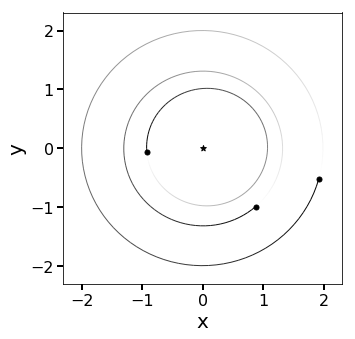

In [15]:
fig = info(21)

# Test Systems

## Stable

* 21: Inner in 3:2 13 RH apart. 13 close to 3:1 (0.01), no resonances bet outer pair (15 RH apart)
* 12: Inner near 6:5 (0.02), outer near 9:7 (0.01). Inner 5.1 RH, outer 6.7 RH
* 17: Inner 3.2 RH apart in 14:13, outer 11.29 RH apart

## Unstable

* 0: 2 and 3 in 12:11 res and 2.6 RH apart. Unstable after 1e6 orbits
* 46: 1 and 2 and 2 and 3 both in 6:5 res. Unstable after 4e4 orbits


## Hard (instability time = 5e7-5e8)

* 68: Eccentric, 1 and 3 in 3:1 resonance, 2 and 3 are closest (10 RH apart) and near 5:3 res
* 110: Hierarchical. Inner 2 very close (7.6 RH aapart) in 5:4, 3rd planet much farther, with 1 and 3 in 3:1
* 176: Eccentric, widely separated (min = 15 RH, max = 27 RH). Strongest res = 5:3 bet 1 and 3, 2 and 3 close to 13:11
* 861: 1 and 3 collide after 8.93e8 orbits. 2 and 3 in 5:3 10.6 RH apart, 1 and 2 close to 2:1. Widely separated, eccentric

In [16]:
def collision(reb_sim, col):
    reb_sim.contents._status = 5
    return 0

from scipy.optimize import brenth
def F(e,alpha,gamma):
    """Equation 35 of Laskar & Petit (2017)"""
    denom = np.sqrt(alpha*(1-e*e)+gamma*gamma*e*e)
    return alpha*e -1 + alpha + gamma*e / denom

### start AMD functions

def critical_relative_AMD(alpha,gamma):
    """Equation 29"""
    e0 = np.min((1,1/alpha-1))
    ec = brenth(F,0,e0,args=(alpha,gamma))
    e1c = np.sin(np.arctan(gamma*ec / np.sqrt(alpha*(1-ec*ec))))
    curlyC = gamma*np.sqrt(alpha) * (1-np.sqrt(1-ec*ec)) + (1 - np.sqrt(1-e1c*e1c))
    return curlyC

def compute_AMD(sim):
    pstar = sim.particles[0]
    Ltot = pstar.m * np.cross(pstar.xyz,pstar.vxyz)
    ps = sim.particles[1:]
    Lmbda=np.zeros(len(ps))
    G = np.zeros(len(ps))
    Lhat = np.zeros((len(ps),3))
    for k,p in enumerate(sim.particles[1:]):
        orb = p.calculate_orbit(primary=pstar)
        Lmbda[k] = p.m * np.sqrt(p.a)
        G[k] = Lmbda[k] * np.sqrt(1-p.e*p.e)
        hvec = np.cross(p.xyz,p.vxyz)
        Lhat[k] = hvec / np.linalg.norm(hvec)
        Ltot = Ltot + p.m * hvec
    cosi = np.array([Lh.dot(Ltot) for Lh in Lhat]) / np.linalg.norm(Ltot)
    return np.sum(Lmbda) - np.sum(G * cosi)

def AMD_stable_Q(sim):
    AMD = compute_AMD(sim)
    pstar = sim.particles[0]
    ps = sim.particles[1:]
    for i in range(len(ps)-1):
        pIn = ps[i]
        pOut = ps[i+1]
        orbIn = pIn.calculate_orbit(pstar)
        orbOut = pOut.calculate_orbit(pstar)
        alpha = orbIn.a / orbOut.a
        gamma = pIn.m / pOut.m
        LmbdaOut = pOut.m * np.sqrt(orbOut.a)
        Ccrit = critical_relative_AMD(alpha,gamma)
        C = AMD / LmbdaOut
        if C>Ccrit:
            return False
    return True

def AMD_stability_coefficient(sim, i1, i2):
    AMD = compute_AMD(sim)
    ps = sim.particles
    pstar = ps[0]
    
    pIn = ps[i1]
    pOut = ps[i2]
    orbIn = pIn.calculate_orbit(pstar)
    orbOut = pOut.calculate_orbit(pstar)
    alpha = orbIn.a / orbOut.a
    gamma = pIn.m / pOut.m
    LmbdaOut = pOut.m * np.sqrt(orbOut.a)
    Ccrit = critical_relative_AMD(alpha,gamma)
    C = AMD / LmbdaOut
    return C / Ccrit

In [17]:
def ZcrossVariation(ID):
    runstring = '{0:07d}.bin'.format(ID)
    snapshot = 0
    sa = rebound.SimulationArchive(respath+sapath+runstring)
    sim = sa[snapshot]

    Norbits = 1e4
    Nout = 1000
    ###############################
    sim.collision_resolve = collision
    sim.ri_whfast.keep_unsynchronized = 1
    sim.ri_whfast.safe_mode = 0
    ##############################

    N = sim.N
    Npairs = int((N-1)*(N-2)/2)
    times = np.linspace(0, Norbits*sim.particles[1].P, Nout)
    eminus = np.zeros((Npairs, Nout))
    Zcross = np.zeros((Npairs, Nout))

    ps = sim.particles
    for i,t in enumerate(times):
        for j, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
            i1, i2 = int(i1), int(i2)
            eminus[j, i] = np.sqrt((ps[i2].e*np.cos(ps[i2].pomega)-ps[i1].e*np.cos(ps[i1].pomega))**2 + (ps[i2].e*np.sin(ps[i2].pomega)-ps[i1].e*np.sin(ps[i1].pomega))**2)
            Zcross[j, i] = (ps[int(i2)].a-ps[int(i1)].a)/ps[int(i1)].a
        try:
            sim.integrate(t, exact_finish_time=0)
        except:
            break
    print('Instability Time = {0:.3e}'.format(sa[-1].t))
    print('Pair 12 RMS Zcross = {0:.3e},  RMS eminus = {1:.3e}, RMS Zcross/Zcross = {2:.3e}'.format(Zcross[0,:].std(), eminus[0,:].std(), Zcross[0,:].std()/Zcross[0,:].mean()))
    print('Pair 13 RMS Zcross = {0:.3e},  RMS eminus = {1:.3e}, RMS Zcross/Zcross = {2:.3e}'.format(Zcross[1,:].std(), eminus[1,:].std(), Zcross[1,:].std()/Zcross[1,:].mean()))
    print('Pair 23 RMS Zcross = {0:.3e},  RMS eminus = {1:.3e}, RMS Zcross/Zcross = {2:.3e}'.format(Zcross[2,:].std(), eminus[2,:].std(), Zcross[2,:].std()/Zcross[2,:].mean()))

    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(times, Zcross[0,:], 'r--', alpha=0.5)
    ax.plot(times, eminus[0,:], 'r.', label='12')
    ax.plot(times, Zcross[1,:], 'b--', alpha=0.5)
    ax.plot(times, eminus[1,:], 'b.', label='13')
    ax.plot(times, Zcross[2,:], 'k--', alpha=0.5)
    ax.plot(times, eminus[2,:], 'k.', label='23')
    ax.legend()
    return fig

# Even in systems that go unstable after a few e4 orbits, Zcross (i.e., the semimajor axes) don't vary appreciably. 

Good approximation to treat them as constants for normalization, just like we do in resonance transformation

Instability Time = 4.552e+04
Pair 12 RMS Zcross = 1.892e-03,  RMS eminus = 7.261e-03, RMS Zcross/Zcross = 1.457e-02
Pair 13 RMS Zcross = 1.589e-04,  RMS eminus = 3.327e-04, RMS Zcross/Zcross = 5.751e-04
Pair 23 RMS Zcross = 1.911e-03,  RMS eminus = 6.685e-03, RMS Zcross/Zcross = 1.475e-02


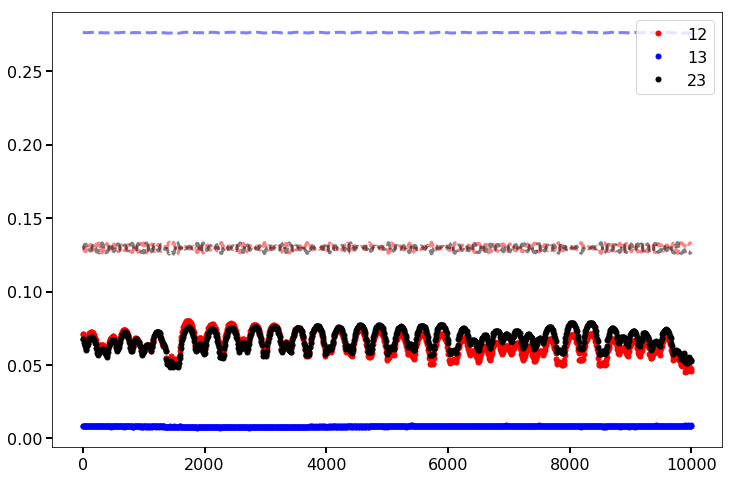

In [88]:
fig = ZcrossVariation(46)

Instability Time = 8.643e+08
Pair 12 RMS Zcross = 4.131e-04,  RMS eminus = 1.792e-02, RMS Zcross/Zcross = 6.455e-04
Pair 13 RMS Zcross = 6.918e-04,  RMS eminus = 1.432e-02, RMS Zcross/Zcross = 5.298e-04
Pair 23 RMS Zcross = 2.226e-04,  RMS eminus = 1.623e-02, RMS Zcross/Zcross = 5.484e-04


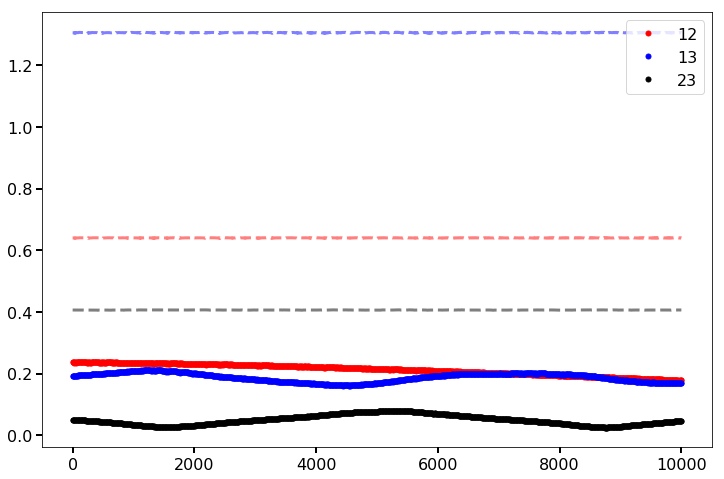

In [39]:
fig = ZcrossVariation(861)

# Counterexample

Assuming that systems like this are easy to classify by other features, so probably OK to assume Zcross = const

Instability Time = 2.226e+04
Pair 12 RMS Zcross = 8.636e-03,  RMS eminus = 8.722e-03, RMS Zcross/Zcross = 1.045e-01
Pair 13 RMS Zcross = 1.093e-03,  RMS eminus = 5.773e-03, RMS Zcross/Zcross = 5.050e-03
Pair 23 RMS Zcross = 8.207e-03,  RMS eminus = 1.380e-02, RMS Zcross/Zcross = 6.633e-02


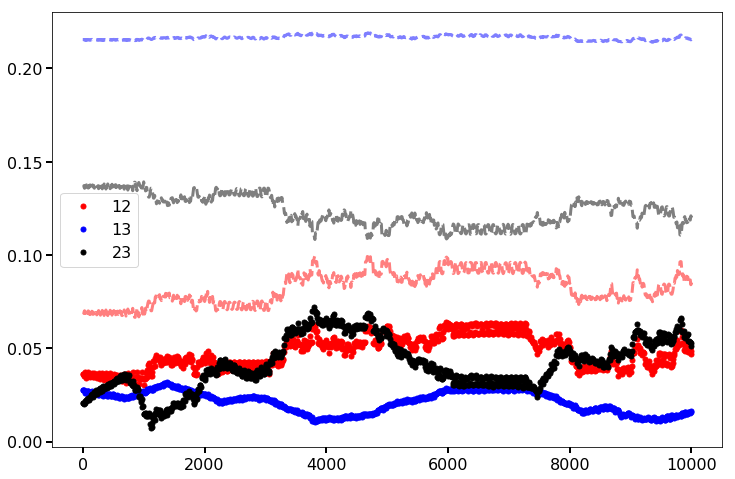

In [41]:
fig = ZcrossVariation(7)

# Plot Variations

In [18]:
def fillnan(features, pairs):
    features['tlyap'] = np.nan
    features['megno'] = np.nan
    
    for i, [label, i1, i2] in enumerate(pairs):
        features['EMmed'+label] = np.nan
        features['EMmax'+label] = np.nan
        features['EMdrift'+label] = np.nan
        features['EMrollingstd'+label] = np.nan
        features['Zcommed'+label] = np.nan
        features['Zsepouter'+label] = np.nan
        features['ZfreeIC'+label] = np.nan
        features['ZfreeOC'+label] = np.nan
        features['Zfree'+label] = np.nan
        features['Zstarmed'+label] = np.nan
        features['Zstarstd'+label] = np.nan
        features['Zstarmed'+label] = np.nan
        features['Zstardrift'+label] = np.nan

def plot(ID):
    
    runstring = '{0:07d}.bin'.format(ID)
    snapshot = 0
    sa = rebound.SimulationArchive(respath+sapath+runstring)
    sim = sa[snapshot]

    Norbits = 1e4
    Nout = 1000
    ###############################
    sim.collision_resolve = collision
    sim.ri_whfast.keep_unsynchronized = 1
    sim.ri_whfast.safe_mode = 0
    ##############################
    features = OrderedDict()
    ps = sim.particles
    sim.init_megno()
    N = sim.N - sim.N_var
    a0 = [0] + [sim.particles[i].a for i in range(1, N)]
    Npairs = int((N-1)*(N-2)/2)
    maxj, maxk, maxi1, maxi2, maxpairindex, maxstrength = -1, -1, -1, -1, -1, -1
    betas = np.zeros(Npairs)
    #print('pairindex, i1, i2, j, k, strength')
    for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        i1 = int(i1); i2 = int(i2)
        RH = ps[i1].a*((ps[i1].m + ps[i2].m)/ps[0].m)**(1./3.)
        betas[i] = (ps[i2].a-ps[i1].a)/RH
        
    features['betaouter'] = betas[1]
    if betas[0] < betas[2]:
        features['nearpair'] = 12 # for visualization and debugging
        features['betanear'] = betas[0]
        features['betafar'] = betas[2]
        pairs = [['near', 1,2], ['far', 2, 3], ['outer', 1, 3]]
    else:
        features['nearpair'] = 23
        features['betanear'] = betas[2]
        features['betafar'] = betas[0]
        pairs = [['near', 2, 3], ['far', 1, 2], ['outer', 1, 3]]
    
    Zsepinners, Zsepouters, separatrixdist = np.zeros(Npairs), np.zeros(Npairs), np.zeros(Npairs)
    for i, [label, i1, i2] in enumerate(pairs):
        features['numfixedpoints'+label] = np.nan
        features['j'+label], features['k'+label], features['strength'+label] = findres2(sim, i1, i2) # returns nans if no res found
        features["C_AMD"+label] = AMD_stability_coefficient(sim, i1, i2)
        features['Zcross'+label] = (ps[int(i2)].a-ps[int(i1)].a)/ps[int(i1)].a
        if np.isnan(features['strength'+label]) == False:
            pvars = Poincare.from_Simulation(sim)
            avars = Andoyer.from_Poincare(pvars, j=features['j'+label], k=features['k'+label], a10=a0[i1], i1=i1, i2=i2)
            features['numfixedpoints'+label] = get_num_fixed_points(features['k'+label], avars.Phiprime)
            Zsepinners[i] = avars.Zsep_inner
            Zsepouters[i] = avars.Zsep_outer
            separatrixdist[i] = min(Zsepouters[i]-avars.Zstar, avars.Zstar-Zsepinners[i])
            
    P0 = ps[1].P
    times = np.linspace(0, Norbits*P0, Nout)
    rebound_Z, rebound_phi = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zcom, rebound_phiZcom = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zstar, rebound_dKprime = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zsepinner, rebound_Zsepouter = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zstarnonres, rebound_Zstarunstable = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    eminus = np.zeros((Npairs,Nout))
    
    features['unstablein1e4'] = False # Assume not and update if true
    for i,t in enumerate(times):
        for j, [label, i1, i2] in enumerate(pairs):
            #i1 = int(i1); i2 = int(i2)
            eminus[j, i] = np.sqrt((ps[i2].e*np.cos(ps[i2].pomega)-ps[i1].e*np.cos(ps[i1].pomega))**2 + (ps[i2].e*np.sin(ps[i2].pomega)-ps[i1].e*np.sin(ps[i1].pomega))**2)
            if np.isnan(features['strength'+label]) == False:
                pvars = Poincare.from_Simulation(sim)
                avars = Andoyer.from_Poincare(pvars, j=features['j'+label], k=features['k'+label], a10=a0[i1], i1=i1, i2=i2)
            
                rebound_Z[j, i] = avars.Z
                rebound_phi[j, i] = avars.phi
                rebound_Zcom[j, i] = avars.Zcom
                rebound_phiZcom[j, i] = avars.phiZcom
                rebound_Zstar[j, i] = avars.Zstar
                rebound_dKprime[j, i] = avars.dKprime
                rebound_Zsepinner[j, i] = avars.Zsep_inner
                rebound_Zsepouter[j, i] = avars.Zsep_outer
                rebound_Zstarnonres[j, i] = avars.Zstar_nonres
                rebound_Zstarunstable[j, i] = avars.Zstar_unstable
        try:
            sim.integrate(t*P0, exact_finish_time=0)
        except:
            features['unstablein1e4'] = True
            break
            
    fillnan(features, pairs)
    if features['unstablein1e4'] == True:
        return 
    
    # Features with or without resonances:
    tlyap = 1./np.abs(sim.calculate_lyapunov())/P0
    if tlyap > Norbits:
        tlyap = Norbits
    features['tlyap'] = tlyap
    features['megno'] = sim.calculate_megno()
    
    for i, [label, i1, i2] in enumerate(pairs):
        Zc = features['Zcross'+label]
        EM = eminus[i,:]/Zc
        features['EMmed'+label] = np.median(EM)
        features['EMmax'+label] = EM.max()
        try:
            p = np.poly1d(np.polyfit(times, EM, 3))
            m = p(times)
            EMdrift = np.abs((m[-1]-m[0])/m[0])
            features['EMdrift'+label] = EMdrift
        except:
            pass
        rollstd = pd.Series(EM).rolling(window=10).std()
        features['EMrollingstd'+label] = rollstd[10:].median()/features['EMmed'+label]
        
        if np.isnan(features['strength'+label]) == False:
            features['Zcommed'+label] = np.median(rebound_Zcom[i,:])
            features['Zsepouter'+label] = Zsepouters[i]/Zc
            
            # try this one generically for variation in constants, since all fixed points seem to follow Zstar closely?
            if np.median(rebound_Zstar[i,:]) > 0:
                features['Zstarstd'+label] = rebound_Zstar[i,:].std()/np.median(rebound_Zstar[i,:])
                
            if np.median(rebound_Z[i,:]) < Zsepinners[i]:
                features['ZfreeIC'+label] = rebound_Z[i,:].max()/Zsepinners[i]
            elif np.median(rebound_Z[i,:]) > Zsepouters[i]:
                features['ZfreeOC'+label] = rebound_Z[i,:].min()/Zsepouters[i]
            else:
                if np.median(rebound_Zstar[i,:]) > 0:
                    features['Zstarmed'+label] = np.median(rebound_Zstar[i,:])/Zc
                    try:
                        p = np.poly1d(np.polyfit(times, rebound_Zstar[i,:], 3))
                        m = p(times)
                        Zstardrift = np.abs((m[-1]-m[0])/m[0])
                        features['Zstardrift'+label] = Zstardrift
                    except:
                        pass
                    features['Zfree'+label] = (rebound_Z[i,:]-rebound_Zstar[i,:]).std()/separatrixdist[i]
    
    fig, axarr = plt.subplots(nrows=7, ncols=3, figsize=(24,24))

    Zlim = 0
    for i in range(3):
        Zlim = max(Zlim, np.max(np.abs(rebound_Z[i,:]/Zcross[i])))

    Zlim *= 1.5

    ax = axarr[0,0]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_Z[i,:]/Zcross[i], '.', label=pairs[i])

    ax.set_ylabel('Z/Zcross')
    ax.set_ylim([0, Zlim])
    ax.legend()

    ax = axarr[0,1]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_phi[i,:], '.', label=pairs[i])

    ax.set_ylabel('phi')
    ax.legend()

    ax = axarr[0,2]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(rebound_Z[i,:]/Zcross[i]*np.cos(rebound_phi[i,:]), rebound_Z[i,:]/Zcross[i]*np.sin(rebound_phi[i,:]), '.', label=pairs[i])

    ax.set_ylabel('Zsinphi/Zcross')
    ax.set_ylabel('Zcosphi/Zcross')
    ax.set_xlim([-Zlim, Zlim])
    ax.set_ylim([-Zlim, Zlim])
    ax.legend()

    ax = axarr[1,0]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_Zstar[i,:]/Zcross[i], '.', label=pairs[i])

    ax.set_ylabel('Zstar/Zcross')
    ax.legend()

    ax = axarr[1,1]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_Zcom[i,:], '.', label=pairs[i])

    ax.set_ylabel('Zcom')
    ax.legend()

    ax = axarr[1,2]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_phiZcom[i,:], '.', label=pairs[i])

    ax.set_ylabel('phiZcom')
    ax.legend()

    ax = axarr[2,0]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_dKprime[i,:], '.', label=pairs[i])

    ax.set_ylabel('dKprime')
    ax.legend()

    ax = axarr[2,1]
    for i in range(3):
        if rebound_Zstarnonres[i,:].mean() > 0:
            ax.plot(times, rebound_Zstarnonres[i,:]/Zcross[i], '.', label=pairs[i])

    ax.set_ylabel('Zstarnonres/Zcross')
    ax.set_ylim([0, Zlim])
    ax.legend()

    ax = axarr[2,2]
    for i in range(3):
        if rebound_Zstarnonres[i,:].mean() > 0:
            ax.plot(times, rebound_Zstarunstable[i,:]/Zcross[i], '.', label=pairs[i])

    ax.set_ylabel('Zstarunstable/Zcross')
    ax.set_ylim([0, Zlim])
    ax.legend()

    ax = axarr[3,0]
    for i in range(3):
        if rebound_Zstarnonres[i,:].mean() > 0:
            ax.plot(times, rebound_Zsepinner[i,:]/Zcross[i], '.', label=pairs[i])

    ax.set_ylabel('Zsepinner/Zcross')
    ax.set_ylim([0, Zlim])
    ax.legend()

    ax = axarr[3,1]
    for i in range(3):
        if rebound_Zstarnonres[i,:].mean() > 0:
            ax.plot(times, rebound_Zsepouter[i,:]/Zcross[i], '.', label=pairs[i])

    ax.set_ylabel('Zsepouter/Zcross')
    ax.set_ylim([0, Zlim])
    ax.legend()
    
    ax = axarr[3,2]
    for i in range(3):
        if rebound_Zstarnonres[i,:].mean() > 0:
            ax.plot(times, (rebound_Zsepouter[i,:]-rebound_Zstar[i,:])/Zcross[i], '.', label=pairs[i])
            ax.plot(times, (rebound_Zstar[i,:]-rebound_Zsepinner[i,:])/Zcross[i], '.', label=pairs[i])

    ax.set_ylabel('(Zsepouter-Zstar)/Zcross')
    ax.set_ylim([0, Zlim])
    ax.legend()
    
    ax = axarr[4, 0]
    for i in range(3):
        if rebound_Zstarnonres[i,:].mean() > 0:
            ax.plot(times, (rebound_Z[i,:]-rebound_Zstar[i,:])/Zcross[i], '.', label=pairs[i])
            
    ax.set_ylabel('(Z-Zstar)/Zcross')
    ax.legend()
    
    ax = axarr[4, 1]
    for i in range(3):
        if rebound_Zsepinner[i,:].mean() > 0:
            ax.plot(times, (rebound_Zsepinner[i,:]-rebound_Z[i,:])/rebound_Zsepinner[i,:], '.', label=pairs[i])
            
    ax.set_ylabel('(Z-Zstar)/Zcross')
    ax.legend()
    
    ax = axarr[5, 0]
            
    for i, [label, i1, i2] in enumerate(pairs):
        Zc = features['Zcross'+label]
        EM = eminus[i,:]/Zc
        ax.plot(times, EM, '.', label=label)
        try:
            p = np.poly1d(np.polyfit(times, EM, 3))
            m = p(times)
            ax.plot(times, m, '--')
            EMdrift = np.abs((m[-1]-m[0])/m[0])
        except:
            pass
    
    ax.set_ylabel('EM/Zc')
    ax.legend()
    
    ax = axarr[6, 0]
            
    for i, [label, i1, i2] in enumerate(pairs):
        if np.isnan(features['strength'+label]) == False:
            if np.isnan(features['ZfreeIC'+label]) == False:
                ax.plot(times, rebound_Z[i,:]/Zsepinners[i], '.', label=label)
    
    ax.set_ylabel('ZfreeIC/Zsepinner')
    ax.legend()
    
    ax = axarr[6, 1]
            
    for i, [label, i1, i2] in enumerate(pairs):
        if np.isnan(features['strength'+label]) == False:
            if np.isnan(features['ZfreeOC'+label]) == False:
                ax.plot(times, rebound_Z[i,:]/Zsepouters[i], '.', label=label)
    
    ax.set_ylabel('ZfreeOC/Zsepouter')
    ax.legend()
    
    ax = axarr[6, 2]
            
    for i, [label, i1, i2] in enumerate(pairs):
        if np.isnan(features['strength'+label]) == False:
            if np.isnan(features['Zfree'+label]) == False:
                ax.plot(times, (rebound_Z[i,:]-rebound_Zstar[i,:])/separatrixdist[i], '.', label=label)
    
    ax.set_ylabel('Zfree/separatrixdist')
    ax.legend()
    
    
    return fig, features

# Using Zcross to determine which is the important 'near' pair, and which is the 'far'. This is what we found in Aanalysis/whichpaircoollides is the best predictor for which pair collide

In [43]:
def fillnan(features, pairs):
    features['tlyap'] = np.nan
    features['megno'] = np.nan
    
    for i, [label, i1, i2] in enumerate(pairs):
        features['EMmed'+label] = np.nan
        features['EMmax'+label] = np.nan
        features['EMdrift'+label] = np.nan
        features['EMrollingstd'+label] = np.nan
        features['Zcommed'+label] = np.nan
        features['Zsepouter'+label] = np.nan
        features['ZfreeIC'+label] = np.nan
        features['ZfreeOC'+label] = np.nan
        features['Zfree'+label] = np.nan
        features['Zstarmed'+label] = np.nan
        features['Zstarstd'+label] = np.nan
        features['Zstarmed'+label] = np.nan
        features['Zstardrift'+label] = np.nan

def plot(ID):  
    runstring = '{0:07d}.bin'.format(ID)
    snapshot = 0
    sa = rebound.SimulationArchive(respath+sapath+runstring)
    sim = sa[snapshot]

    Norbits = 1e4
    Nout = 1000
    ###############################
    sim.collision_resolve = collision
    sim.ri_whfast.keep_unsynchronized = 1
    sim.ri_whfast.safe_mode = 0
    ##############################
    features = OrderedDict()
    ps = sim.particles
    sim.init_megno()
    N = sim.N - sim.N_var
    a0 = [0] + [sim.particles[i].a for i in range(1, N)]
    Npairs = int((N-1)*(N-2)/2)
    maxj, maxk, maxi1, maxi2, maxpairindex, maxstrength = -1, -1, -1, -1, -1, -1
    betas, Zcross = np.zeros(Npairs), np.zeros(Npairs)
    #print('pairindex, i1, i2, j, k, strength')
    for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        i1 = int(i1); i2 = int(i2)
        RH = ps[i1].a*((ps[i1].m + ps[i2].m)/ps[0].m)**(1./3.)
        betas[i] = (ps[i2].a-ps[i1].a)/RH
        Zcross[i] = (ps[int(i2)].a-ps[int(i1)].a)/ps[int(i1)].a / np.sqrt(2) # IMPORTANT FACTOR OF SQRT(2)! Z = EM/sqrt(2)
        
    features['betaouter'] = betas[1]
    if Zcross[0] < Zcross[2]: # 0 = '1-2', 2='2-3'
        features['nearpair'] = 12 # for visualization and debugging
        features['betanear'] = betas[0]
        features['betafar'] = betas[2]
        pairs = [['near', 1,2], ['far', 2, 3], ['outer', 1, 3]]
    else:
        features['nearpair'] = 23
        features['betanear'] = betas[2]
        features['betafar'] = betas[0]
        pairs = [['near', 2, 3], ['far', 1, 2], ['outer', 1, 3]]
    
    Zsepinners, Zsepouters, separatrixdist = np.zeros(Npairs), np.zeros(Npairs), np.zeros(Npairs)
    for i, [label, i1, i2] in enumerate(pairs):
        features['numfixedpoints'+label] = np.nan
        features['j'+label], features['k'+label], features['strength'+label] = findres2(sim, i1, i2) # returns nans if no res found
        features["C_AMD"+label] = AMD_stability_coefficient(sim, i1, i2)
        features['Zcross'+label] = (ps[int(i2)].a-ps[int(i1)].a)/ps[int(i1)].a
        if np.isnan(features['strength'+label]) == False:
            pvars = Poincare.from_Simulation(sim)
            avars = Andoyer.from_Poincare(pvars, j=features['j'+label], k=features['k'+label], a10=a0[i1], i1=i1, i2=i2)
            features['numfixedpoints'+label] = get_num_fixed_points(features['k'+label], avars.Phiprime)
            Zsepinners[i] = avars.Zsep_inner
            Zsepouters[i] = avars.Zsep_outer
            separatrixdist[i] = min(Zsepouters[i]-avars.Zstar, avars.Zstar-Zsepinners[i])
            
    P0 = ps[1].P
    times = np.linspace(0, Norbits*P0, Nout)
    rebound_Z, rebound_phi = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zcom, rebound_phiZcom = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zstar, rebound_dKprime = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zsepinner, rebound_Zsepouter = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zstarnonres, rebound_Zstarunstable = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    eminus = np.zeros((Npairs,Nout))
    
    features['unstablein1e4'] = False # Assume not and update if true
    for i,t in enumerate(times):
        for j, [label, i1, i2] in enumerate(pairs):
            #i1 = int(i1); i2 = int(i2)
            eminus[j, i] = np.sqrt((ps[i2].e*np.cos(ps[i2].pomega)-ps[i1].e*np.cos(ps[i1].pomega))**2 + (ps[i2].e*np.sin(ps[i2].pomega)-ps[i1].e*np.sin(ps[i1].pomega))**2)
            if np.isnan(features['strength'+label]) == False:
                pvars = Poincare.from_Simulation(sim)
                avars = Andoyer.from_Poincare(pvars, j=features['j'+label], k=features['k'+label], a10=a0[i1], i1=i1, i2=i2)
            
                rebound_Z[j, i] = avars.Z
                rebound_phi[j, i] = avars.phi
                rebound_Zcom[j, i] = avars.Zcom
                rebound_phiZcom[j, i] = avars.phiZcom
                rebound_Zstar[j, i] = avars.Zstar
                rebound_dKprime[j, i] = avars.dKprime
                rebound_Zsepinner[j, i] = avars.Zsep_inner
                rebound_Zsepouter[j, i] = avars.Zsep_outer
                rebound_Zstarnonres[j, i] = avars.Zstar_nonres
                rebound_Zstarunstable[j, i] = avars.Zstar_unstable
        try:
            sim.integrate(t*P0, exact_finish_time=0)
        except:
            features['unstablein1e4'] = True
            break
            
    fillnan(features, pairs)
    if features['unstablein1e4'] == True:
        return 
    
    # Features with or without resonances:
    tlyap = 1./np.abs(sim.calculate_lyapunov())/P0
    if tlyap > Norbits:
        tlyap = Norbits
    features['tlyap'] = tlyap
    features['megno'] = sim.calculate_megno()
    
    for i, [label, i1, i2] in enumerate(pairs):
        Zc = features['Zcross'+label]
        EM = eminus[i,:]/Zc
        features['EMmed'+label] = np.median(EM)
        features['EMmax'+label] = EM.max()
        try:
            p = np.poly1d(np.polyfit(times, EM, 3))
            m = p(times)
            EMdrift = np.abs((m[-1]-m[0])/m[0])
            features['EMdrift'+label] = EMdrift
        except:
            pass
        rollstd = pd.Series(EM).rolling(window=10).std()
        features['EMrollingstd'+label] = rollstd[10:].median()/features['EMmed'+label]
        
        if np.isnan(features['strength'+label]) == False:
            features['Zcommed'+label] = np.median(rebound_Zcom[i,:])
            features['Zsepouter'+label] = Zsepouters[i]/Zc
            
            # try this one generically for variation in constants, since all fixed points seem to follow Zstar closely?
            if np.median(rebound_Zstar[i,:]) > 0:
                features['Zstarstd'+label] = rebound_Zstar[i,:].std()/np.median(rebound_Zstar[i,:])
                
            if np.median(rebound_Z[i,:]) < Zsepinners[i]:
                features['ZfreeIC'+label] = rebound_Z[i,:].max()/Zsepinners[i]
            elif np.median(rebound_Z[i,:]) > Zsepouters[i]:
                features['ZfreeOC'+label] = rebound_Z[i,:].min()/Zsepouters[i]
            else:
                if np.median(rebound_Zstar[i,:]) > 0:
                    features['Zstarmed'+label] = np.median(rebound_Zstar[i,:])/Zc
                    try:
                        p = np.poly1d(np.polyfit(times, rebound_Zstar[i,:], 3))
                        m = p(times)
                        Zstardrift = np.abs((m[-1]-m[0])/m[0])
                        features['Zstardrift'+label] = Zstardrift
                    except:
                        pass
                    features['Zfree'+label] = (rebound_Z[i,:]-rebound_Zstar[i,:]).std()/separatrixdist[i]
    
    fig, axarr = plt.subplots(nrows=4, ncols=3, figsize=(24,24))

    Zlim = 0
    for i, [label, i1, i2] in enumerate(pairs):
        Zlim = max(Zlim, np.max(np.abs(rebound_Z[i,:]/Zcross[i])))

    Zlim *= 1.5

    colors = ['orange', 'green', 'blue']
    
    for i, [label, i1, i2] in enumerate(pairs):
        ax = axarr[0,i]
        if rebound_Z[i,:].mean() > 0:
            ax.plot(rebound_Z[i,:]/Zcross[i]*np.cos(rebound_phi[i,:]), rebound_Z[i,:]/Zcross[i]*np.sin(rebound_phi[i,:]), '.', label=label, color=colors[i])

        ax.set_ylabel('Zsinphi/Zcross')
        ax.set_ylabel('Zcosphi/Zcross')
        ax.set_xlim([-Zlim, Zlim])
        ax.set_ylim([-Zlim, Zlim])
        ax.set_aspect('equal')
        ax.legend()
    
    ax = axarr[1,0]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_Z[i,:]/Zcross[i], '.', label=pairs[i], color=colors[i])
    ax.set_ylim([0, Zlim])
    ax.set_ylabel('Z/Zcross')
    ax.legend()
    
    ax = axarr[1,1]
    for i in range(3):
        ax.plot(times, eminus[i,:]/np.sqrt(2)/Zcross[i], '.', label=pairs[i], color=colors[i])
    ax.set_ylim([0, Zlim])
    ax.set_ylabel('EM/EMcross')
    ax.legend()
    
    ax = axarr[2,0]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_Zcom[i,:]/Zcross[i], '.', label=pairs[i], color=colors[i])

    ax.set_ylabel('Zcom/Zcross')
    ax.legend()

    ax = axarr[2,1]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_phiZcom[i,:], '.', label=pairs[i], color=colors[i])

    ax.set_ylabel('phiZcom')
    ax.legend()
    
    ax = axarr[2, 2]
    for i in range(3):
        if rebound_Zstarnonres[i,:].mean() > 0:
            ax.plot(times, (rebound_Z[i,:]-rebound_Zstar[i,:])/Zcross[i], '.', label=pairs[i], color=colors[i])

    ax.set_ylabel('(Z-Zstar)/Zcross')
    ax.legend()

    ax = axarr[3,0]
    for i in range(3):
        if rebound_Z[i,:].mean() > 0:
            ax.plot(times, rebound_Zstar[i,:]/Zcross[i], '.', label=pairs[i], color=colors[i])

    ax.set_ylim([0, Zlim])
    ax.set_ylabel('Zstar/Zcross')
    ax.legend()

    ax = axarr[3,1]
    for i in range(3):
        if rebound_Zstarnonres[i,:].mean() > 0:
            ax.plot(times, rebound_Zsepouter[i,:]/Zcross[i], '.', label=pairs[i], color=colors[i])

    ax.set_ylabel('Zsepouter/Zcross')
    ax.set_ylim([0, Zlim])
    ax.legend()

    ax = axarr[3,2]
    for i in range(3):
        if rebound_Zstarnonres[i,:].mean() > 0:
            ax.plot(times, (rebound_Zsepouter[i,:]-rebound_Zstar[i,:])/Zcross[i], '.', label=pairs[i], color=colors[i])
            ax.plot(times, (rebound_Zstar[i,:]-rebound_Zsepinner[i,:])/Zcross[i], '.', label=pairs[i], color=colors[i])

    Zsepouteravg = ((rebound_Zsepouter[i,:]-rebound_Zstar[i,:])/Zcross[i]).mean()
    Zsepinneravg = ((rebound_Zstar[i,:]-rebound_Zsepinner[i,:])/Zcross[i]).mean()
    print('Zsepouter = {0}, Zsepinner = {1}, fractional error = {2}'.format(Zsepouteravg, Zsepinneravg, np.abs((Zsepouteravg-Zsepinneravg)/Zsepinneravg)))
    ax.set_ylim([0, Zlim])
    ax.set_ylabel('(Zsepouter-Zstar)/Zcross')
    ax.legend()


    return fig, features

# Test Systems

## Stable

* 21: Inner in 3:2 13 RH apart. 13 close to 3:1 (0.01), no resonances bet outer pair (15 RH apart)
* 12: Inner near 6:5 (0.02), outer near 9:7 (0.01). Inner 5.1 RH, outer 6.7 RH
* 17: Inner 3.2 RH apart in 14:13, outer 11.29 RH apart

## Unstable

* 0: 2 and 3 in 12:11 res and 2.6 RH apart. Unstable after 1e6 orbits
* 46: 1 and 2 and 2 and 3 both in 6:5 res. Unstable after 4e4 orbits


## Hard (instability time = 5e7-5e8)

* 68: Eccentric, 1 and 3 in 3:1 resonance, 2 and 3 are closest (10 RH apart) and near 5:3 res
* 110: Hierarchical. Inner 2 very close (7.6 RH aapart) in 5:4, 3rd planet much farther, with 1 and 3 in 3:1
* 176: Eccentric, widely separated (min = 15 RH, max = 27 RH). Strongest res = 5:3 bet 1 and 3, 2 and 3 close to 13:11
* 861: 1 and 3 collide after 8.93e8 orbits. 2 and 3 in 5:3 10.6 RH apart, 1 and 2 close to 2:1. Widely separated, eccentric

## Unstable mess

* 7 Goes unstable in 2e4, big Zcross variations

Particles [1, 2] collided at t = 5.19e+06
Pair 12: Zcross = 0.383, Z/Zcross = 0.280, delta a/RH = 13.23, Strongest Resonance (strength) = 5:3 (0.02)
Pair 13: Zcross = 0.812, Z/Zcross = 0.062, delta a/RH = 35.79, Strongest Resonance = None
Pair 23: Zcross = 0.310, Z/Zcross = 0.222, delta a/RH = 9.67, Strongest Resonance (strength) = 3:2 (8.83)


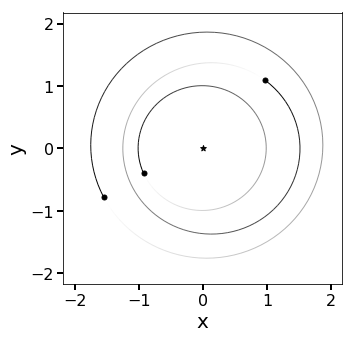

In [46]:
ID = 8065
fig = info(ID)

No handles with labels found to put in legend.
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:245: RuntimeWarning: invalid value encountered in double_scalars


Zsepouter = 0.0, Zsepinner = 0.0, fractional error = nan
CPU times: user 12.5 s, sys: 138 ms, total: 12.7 s
Wall time: 7.82 s


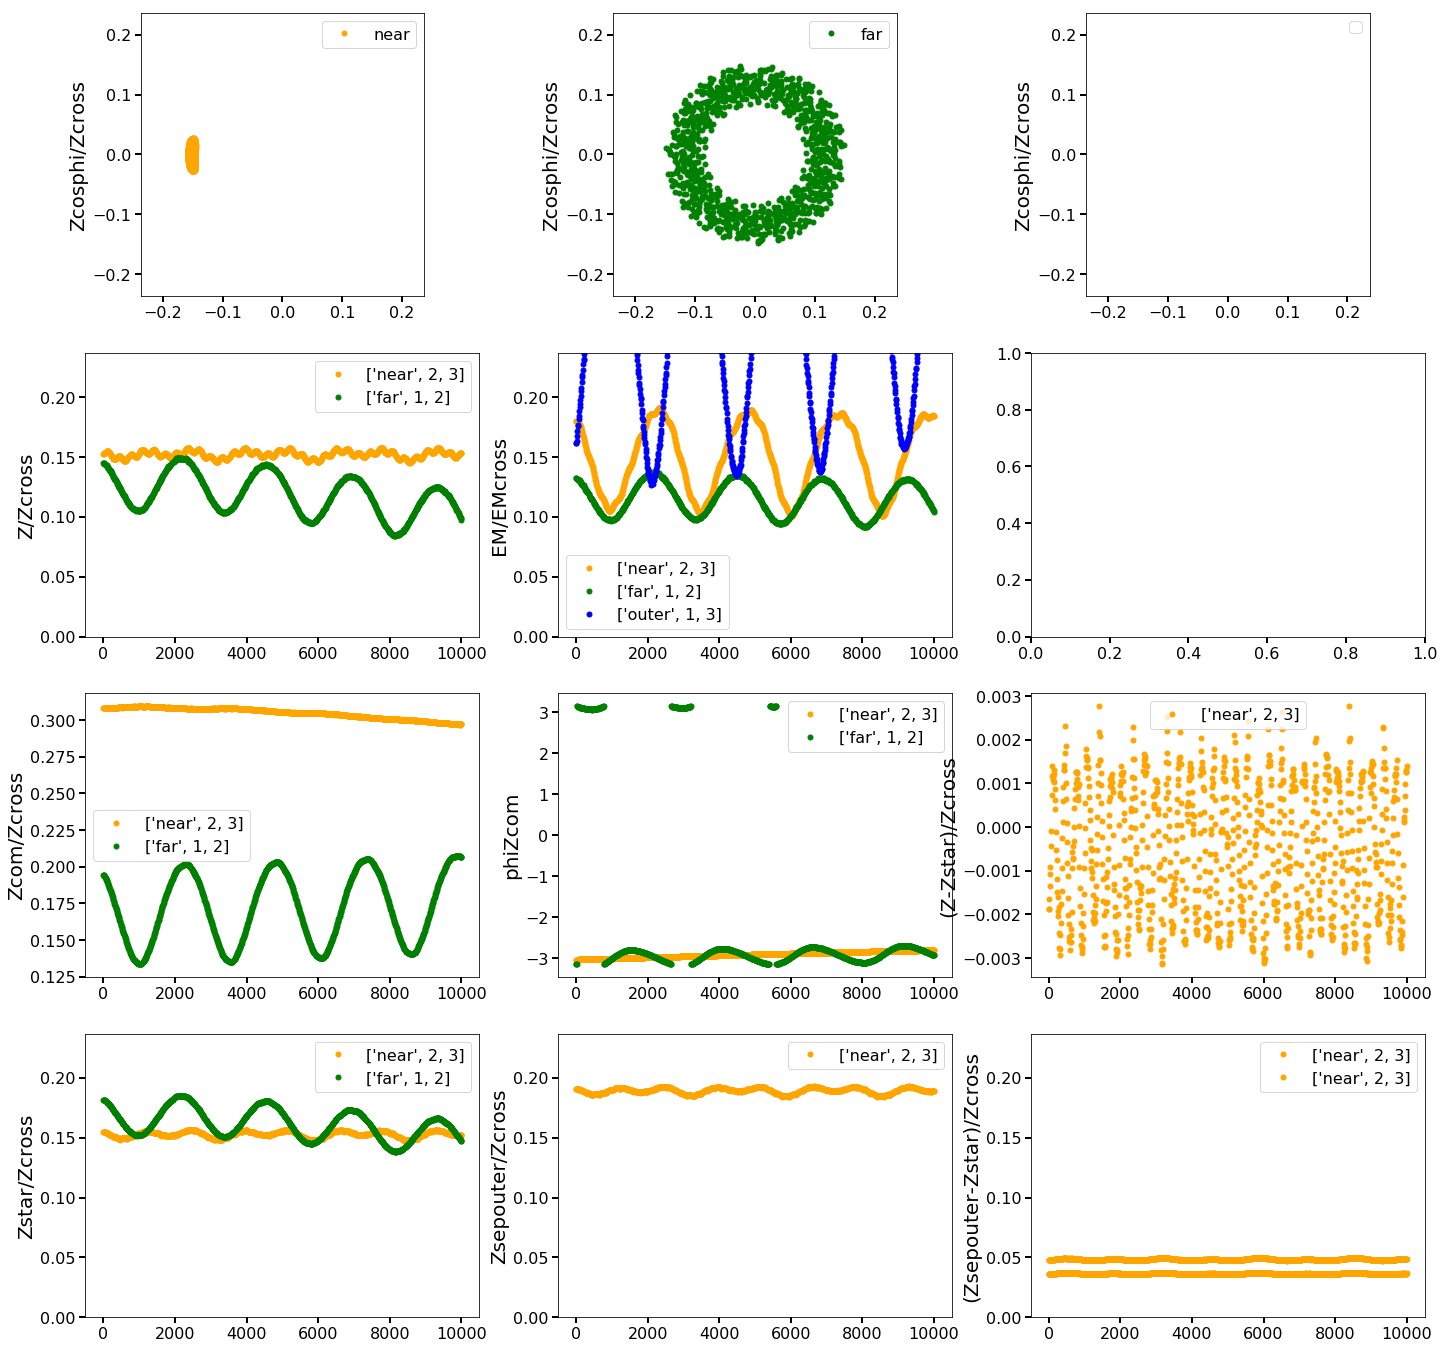

In [47]:
%%time
fig, features = plot(ID)

- Are mispredicted systems trading AMD?
- Run them for longer and see
- track script A from Sam's paper ~ Zcom + Zstar (see below his Eq. 18). This is strictly conserved in the two planet problem, and is equivalent to the system's AMD if you average over a MMR libration cycle
- Plot Z/Zcross where resonances overlap in 2 planet problem and Zstar/Zcross where that happens to see when you hit it
- pragmatic solution is when you see a secular drift, integrate longer to resolve a cycle
- make sure you keep track of the sqrt(2) factor in Z relative to eminus and orbit crossing

In [5]:
ID = 0
runstring = '{0:07d}.bin'.format(ID)
snapshot = 0
sa = rebound.SimulationArchive(respath+sapath+runstring)
sim = sa[snapshot]
sys.path.append('../generate_training_data/')
from training_data_functions import ressummaryfeaturesxgbv3
features = ressummaryfeaturesxgbv3(sim, (1e4, 1000))
print(len(features))

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:98: UserWarning: k=1 resonance has no separatrix for Phiprime < 1
  warnings.warn("k=1 resonance has no separatrix for Phiprime < 1")
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:74: UserWarning: k=1 resonance does not have a non-resonant fixed point for Phiprime < 1
  warnings.warn("k=1 resonance does not have a non-resonant fixed point for Phiprime < 1")
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:52: UserWarning: k=1 resonance has no unstable fixed point for Phiprime < 1
  warnings.warn("k=1 resonance has no unstable fixed point for Phiprime < 1")


61


In [ ]:
features

In [259]:
features

OrderedDict([('betaouter', 12.748580599409955),
             ('nearpair', 23),
             ('betanear', 7.155678371876131),
             ('betafar', 7.857495811077149),
             ('jnear', 6),
             ('knear', 1),
             ('strengthnear', 10.61023034220886),
             ('C_AMDnear', 2.984748665430162),
             ('Zcrossnear', 0.12926881444992766),
             ('numfixedpointsnear', 3),
             ('jfar', 6),
             ('kfar', 1),
             ('strengthfar', 0.23537929032021332),
             ('C_AMDfar', 3.748322976254413),
             ('Zcrossfar', 0.13027644816363979),
             ('numfixedpointsfar', 3),
             ('jouter', 3),
             ('kouter', 1),
             ('strengthouter', 0.006964044996686422),
             ('C_AMDouter', 0.04240423858365344),
             ('Zcrossouter', 0.27638594461842864),
             ('numfixedpointsouter', 3),
             ('unstablein1e4', False),
             ('tlyap', 1120.3880278279587),
             ('me

In [225]:
label = 'near'
print(features['EMmed'+label])
print(features['EMmax'+label])
print(features['EMdrift'+label])
print(features['EMdetrendedstd'+label])
print(features['EMrollingstd'+label])

0.22722678526403084
0.27249431286302045
0.7443157557808265
0.021704424055856444
0.007577171100471352
0.0046743074227044564


In [174]:
ID = 110
runstring = '{0:07d}.bin'.format(ID)
snapshot = 0
sa = rebound.SimulationArchive(respath+sapath+runstring)
sim = sa[snapshot]

Norbits = 1e4
Nout = 1000
###############################
sim.collision_resolve = collision
sim.ri_whfast.keep_unsynchronized = 1
sim.ri_whfast.safe_mode = 0
##############################
features = OrderedDict()
AMDcoeffs = AMD_stability_coefficients(sim)
features["C_AMD12"] = AMDcoeffs[0]
features["C_AMD23"] = AMDcoeffs[1]
features["C_AMD_max"] = np.max(AMDcoeffs)
ps = sim.particles
sim.init_megno()
N = sim.N - sim.N_var
a0 = [0] + [sim.particles[i].a for i in range(1, N)]
Npairs = int((N-1)*(N-2)/2)
js, ks, strengths = np.zeros(Npairs, dtype=np.int), np.zeros(Npairs, dtype=np.int), np.zeros(Npairs)
maxj, maxk, maxi1, maxi2, maxpairindex, maxstrength = -1, -1, -1, -1, -1, -1
Zcross = np.zeros(Npairs)
#print('pairindex, i1, i2, j, k, strength')
for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
    js[i], ks[i], strengths[i] = findres2(sim, i1, i2)
    Zcross[i] = (ps[int(i2)].a-ps[int(i1)].a)/ps[int(i1)].a
    #print(i, i1, i2, js[i], ks[i], strengths[i])
    if strengths[i] > maxstrength:
        maxj, maxk, maxi1, maxi2, maxpairindex, maxstrength = js[i], ks[i], i1, i2, i, strengths[i]
features['Zcross12'] = Zcross[0]
features['Zcross13'] = Zcross[1]
features['Zcross23'] = Zcross[2]
features['maxj'] = maxj
features['maxk'] = maxk
features['maxi1'] = maxi1
features['maxi2'] = maxi2
features['maxstrength'] = maxstrength
sortedstrengths = strengths.copy()
sortedstrengths.sort()
if sortedstrengths[-1] > 0 and sortedstrengths[-2] > 0:
    features['secondres'] = sortedstrengths[-2]/sortedstrengths[-1]
else:
    features['secondres'] = -1

#print('max', maxi1, maxi2, maxj, maxk, maxpairindex, maxstrength)
#print('df (j, k, pairindex):', features['j'], features['k'], features['pairindex'])
times = np.linspace(0, Norbits*sim.particles[1].P, Nout)
eminus = np.zeros((Npairs, Nout))
rebound_Z, rebound_phi = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
rebound_Zcom, rebound_phiZcom = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
rebound_Zstar, rebound_dKprime = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
rebound_Zsepinner, rebound_Zsepouter = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
rebound_Zstarnonres, rebound_Zstarunstable = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
Zcrossseries = np.zeros((Npairs,Nout))
celmech_Z, celmech_phi = np.zeros(Nout), np.zeros(Nout)
celmech_Zcom, celmech_phiZcom = np.zeros(Nout), np.zeros(Nout)
celmech_Zstar, celmech_dKprime = np.zeros(Nout), np.zeros(Nout)
for i,t in enumerate(times):
    for j, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        i1, i2 = int(i1), int(i2)
        Zcrossseries[j,i] = (ps[i2].a-ps[i1].a)/ps[i1].a
        eminus[j, i] = np.sqrt((ps[i2].e*np.cos(ps[i2].pomega)-ps[i1].e*np.cos(ps[i1].pomega))**2 + (ps[i2].e*np.sin(ps[i2].pomega)-ps[i1].e*np.sin(ps[i1].pomega))**2)
        if js[j] != -1:
            pvars = Poincare.from_Simulation(sim)
            avars = Andoyer.from_Poincare(pvars, j=js[j], k=ks[j], a10=a0[i1], i1=i1, i2=i2)
            rebound_Z[j, i] = avars.Z
            rebound_phi[j, i] = avars.phi
            rebound_Zcom[j, i] = avars.Zcom
            rebound_phiZcom[j, i] = avars.phiZcom
            rebound_Zstar[j, i] = avars.Zstar
            rebound_dKprime[j, i] = avars.dKprime
            rebound_Zsepinner[j, i] = avars.Zsep_inner
            rebound_Zsepouter[j, i] = avars.Zsep_outer
            rebound_Zstarnonres[j, i] = avars.Zstar_nonres
            rebound_Zstarunstable[j, i] = avars.Zstar_unstable
    try:
        sim.integrate(t, exact_finish_time=0)
    except:
        break
mask = eminus[0] > 0 # where there are data points in case sim ends early
times = times[mask]
eminus = eminus[:, mask]
rebound_Z, rebound_phi = rebound_Z[:, mask], rebound_phi[:, mask]
rebound_Zcom, rebound_phiZcom =  rebound_Zcom[:, mask], rebound_phiZcom[:, mask]
rebound_Zstar, rebound_dKprime = rebound_Zstar[:, mask], rebound_dKprime[:, mask]
celmech_Z, celmech_phi, celmech_Zcom, celmech_phiZcom = celmech_Z[mask], celmech_phi[mask], celmech_Zcom[mask], celmech_phiZcom[mask]
celmech_Zstar, celmech_dKprime = celmech_Zstar[mask], celmech_dKprime[mask]

Zsepouter = 0.0, Zsepinner = 0.0, fractional error = nan


/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in double_scalars


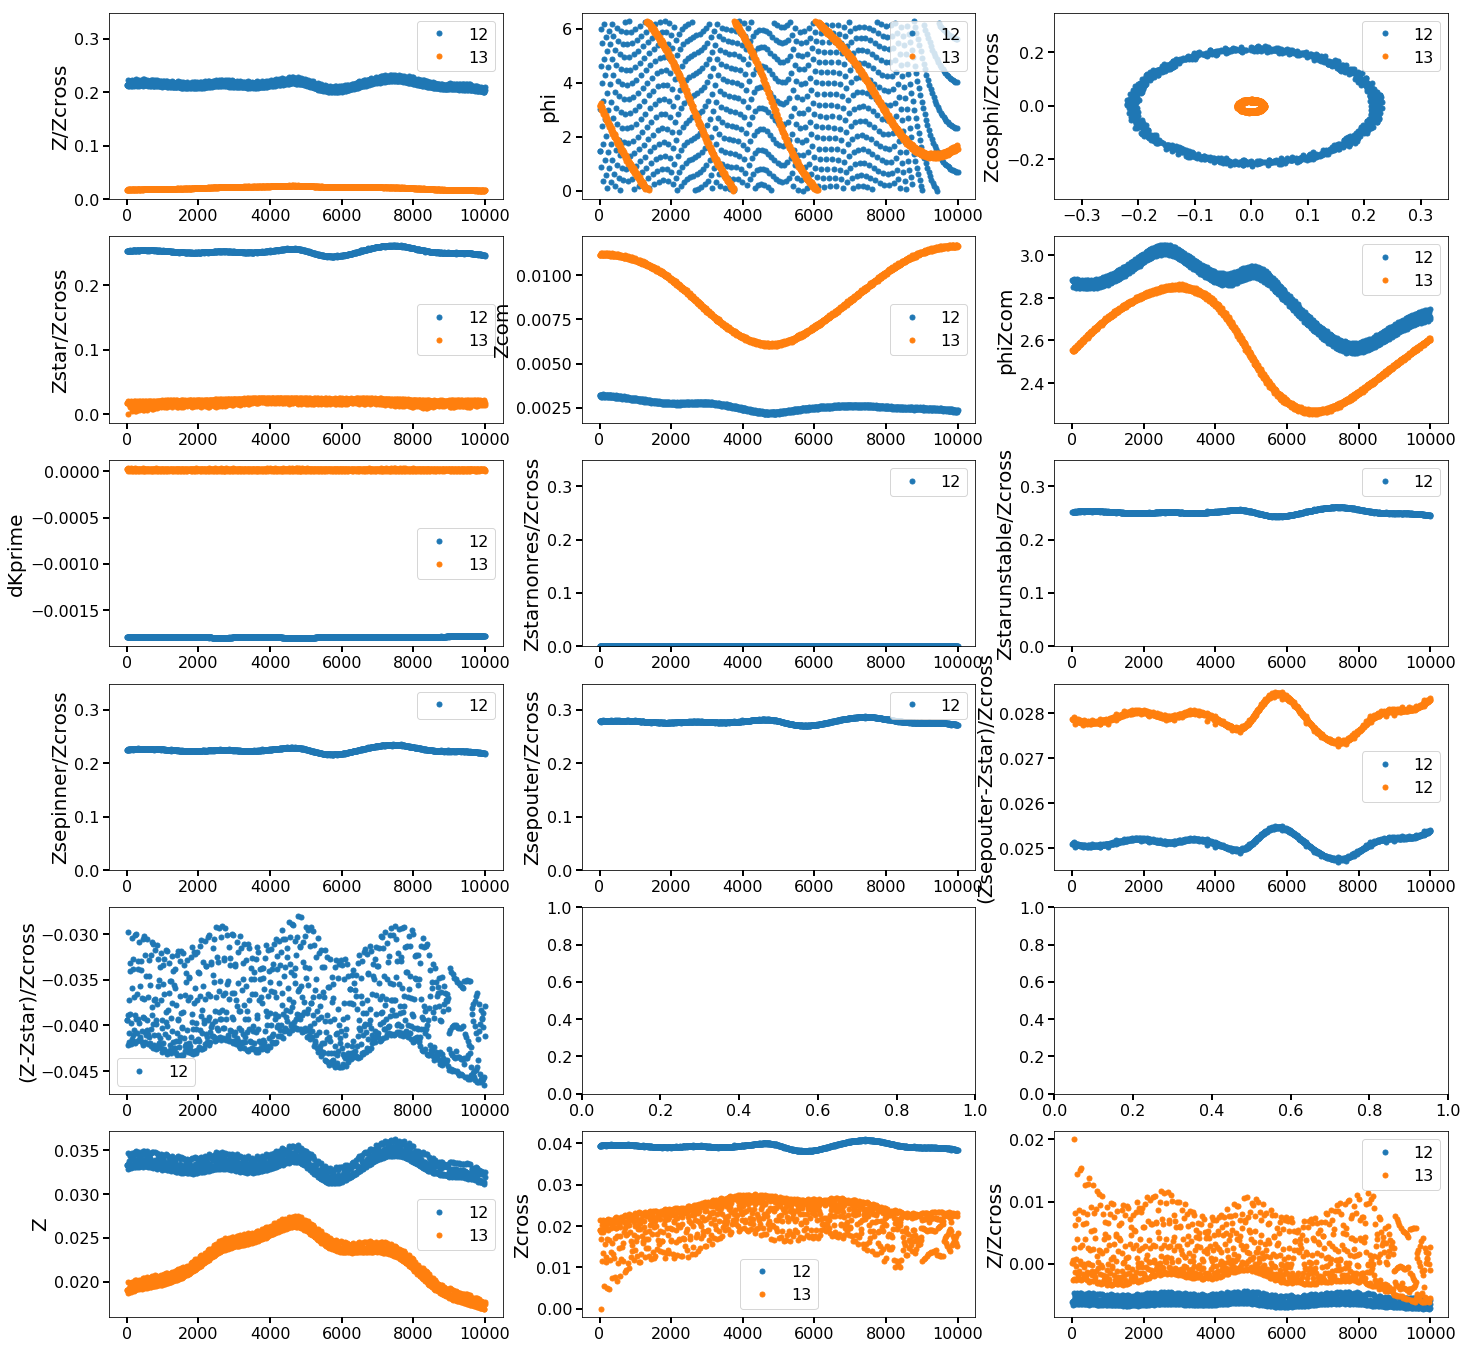

In [175]:
fig, axarr = plt.subplots(nrows=6, ncols=3, figsize=(24,24))

pairs = ['12', '13', '23'] # order we get back from itertools combinations
Zlim = 0
for i in range(3):
    Zlim = max(Zlim, np.max(np.abs(rebound_Z[i,:]/Zcross[i])))

Zlim *= 1.5

ax = axarr[0,0]
for i in range(3):
    if rebound_Z[i,:].mean() > 0:
        ax.plot(times, rebound_Z[i,:]/Zcross[i], '.', label=pairs[i])

ax.set_ylabel('Z/Zcross')
ax.set_ylim([0, Zlim])
ax.legend()

ax = axarr[0,1]
for i in range(3):
    if rebound_Z[i,:].mean() > 0:
        ax.plot(times, rebound_phi[i,:], '.', label=pairs[i])

ax.set_ylabel('phi')
ax.legend()

ax = axarr[0,2]
for i in range(3):
    if rebound_Z[i,:].mean() > 0:
        Zclean = rebound_Z[i,:]# - (rebound_Zstar[i,:] - rebound_Zstar[i,0])
        ax.plot(Zclean/Zcross[i]*np.cos(rebound_phi[i,:]), Zclean/Zcross[i]*np.sin(rebound_phi[i,:]), '.', label=pairs[i])

ax.set_ylabel('Zsinphi/Zcross')
ax.set_ylabel('Zcosphi/Zcross')
ax.set_xlim([-Zlim, Zlim])
ax.set_ylim([-Zlim, Zlim])
ax.legend()

ax = axarr[1,0]
for i in range(3):
    if rebound_Z[i,:].mean() > 0:
        ax.plot(times, rebound_Zstar[i,:]/Zcross[i], '.', label=pairs[i])

ax.set_ylabel('Zstar/Zcross')
ax.legend()

ax = axarr[1,1]
for i in range(3):
    if rebound_Z[i,:].mean() > 0:
        ax.plot(times, rebound_Zcom[i,:], '.', label=pairs[i])

ax.set_ylabel('Zcom')
ax.legend()

ax = axarr[1,2]
for i in range(3):
    if rebound_Z[i,:].mean() > 0:
        ax.plot(times, rebound_phiZcom[i,:], '.', label=pairs[i])

ax.set_ylabel('phiZcom')
ax.legend()

ax = axarr[2,0]
for i in range(3):
    if rebound_Z[i,:].mean() > 0:
        ax.plot(times, rebound_dKprime[i,:], '.', label=pairs[i])

ax.set_ylabel('dKprime')
ax.legend()

ax = axarr[2,1]
for i in range(3):
    if rebound_Zstarnonres[i,:].mean() > 0:
        ax.plot(times, rebound_Zstarnonres[i,:]/Zcross[i], '.', label=pairs[i])

ax.set_ylabel('Zstarnonres/Zcross')
ax.set_ylim([0, Zlim])
ax.legend()

ax = axarr[2,2]
for i in range(3):
    if rebound_Zstarnonres[i,:].mean() > 0:
        ax.plot(times, rebound_Zstarunstable[i,:]/Zcross[i], '.', label=pairs[i])

ax.set_ylabel('Zstarunstable/Zcross')
ax.set_ylim([0, Zlim])
ax.legend()

ax = axarr[3,0]
for i in range(3):
    if rebound_Zstarnonres[i,:].mean() > 0:
        ax.plot(times, rebound_Zsepinner[i,:]/Zcross[i], '.', label=pairs[i])

ax.set_ylabel('Zsepinner/Zcross')
ax.set_ylim([0, Zlim])
ax.legend()

ax = axarr[3,1]
for i in range(3):
    if rebound_Zstarnonres[i,:].mean() > 0:
        ax.plot(times, rebound_Zsepouter[i,:]/Zcross[i], '.', label=pairs[i])

ax.set_ylabel('Zsepouter/Zcross')
ax.set_ylim([0, Zlim])
ax.legend()

ax = axarr[3,2]
for i in range(3):
    if rebound_Zstarnonres[i,:].mean() > 0:
        ax.plot(times, (rebound_Zsepouter[i,:]-rebound_Zstar[i,:])/Zcross[i], '.', label=pairs[i])
        ax.plot(times, (rebound_Zstar[i,:]-rebound_Zsepinner[i,:])/Zcross[i], '.', label=pairs[i])

Zsepouteravg = ((rebound_Zsepouter[i,:]-rebound_Zstar[i,:])/Zcross[i]).mean()
Zsepinneravg = ((rebound_Zstar[i,:]-rebound_Zsepinner[i,:])/Zcross[i]).mean()
print('Zsepouter = {0}, Zsepinner = {1}, fractional error = {2}'.format(Zsepouteravg, Zsepinneravg, np.abs((Zsepouteravg-Zsepinneravg)/Zsepinneravg)))
ax.set_ylabel('(Zsepouter-Zstar)/Zcross')
ax.legend()

ax = axarr[4, 0]
for i in range(3):
    if rebound_Zstarnonres[i,:].mean() > 0:
        ax.plot(times, (rebound_Z[i,:]-rebound_Zstar[i,:])/Zcross[i], '.', label=pairs[i])

ax.set_ylabel('(Z-Zstar)/Zcross')
ax.legend()

ax = axarr[5, 0]
for i in range(3):
    if rebound_Z[i,:].mean() > 0:
        ax.plot(times, rebound_Z[i,:], '.', label=pairs[i])

ax.set_ylabel('Z')
ax.legend()

ax = axarr[5, 1]
for i in range(3):
    if rebound_Z[i,:].mean() > 0:
        ax.plot(times, rebound_Zstar[i,:], '.', label=pairs[i])

ax.set_ylabel('Zcross')
ax.legend()

ax = axarr[5, 2]
for i in range(3):
    if rebound_Z[i,:].mean() > 0:
        ax.plot(times, rebound_Z[i,:]-rebound_Zstar[i,:], '.', label=pairs[i])

ax.set_ylabel('Z/Zcross')
ax.legend()

# Observations

* Long-timescale perturbations (presumably resonant, secular) affect the resonant variables, but seemingly all in the same way, so e.g. Zsepouter - Zstar is much more stable than Zsepouter. Can use same std for all the Zstars
* Distance from Zstar to separatrix in each direction is the same to within 10\% or so?